In [1]:
import os
from PIL import Image
import numpy as np
import time
from multiprocessing import Pool
import random
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset,ChainDataset
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
import io
import pandas as pd 
import torch.nn as nn
import torch.optim as optim
import zipfile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
torch.backends.cuda.matmul.allow_tf32 = False

torch.cuda.empty_cache()
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

if cuda_available:
    # Get the CUDA version
    cuda_version = torch.version.cuda
    print("CUDA version:", cuda_version)


PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7


In [2]:
import concurrent.futures
import os
import time
import numpy as np
from PIL import Image

folder1 = "images"
folder2 = "distorted"
target_size = (128, 128)

files1 = sorted(file for file in os.listdir(folder1) if file.lower().endswith(".jpg"))
files2 = sorted(file for file in os.listdir(folder2) if file.lower().endswith(".jpeg"))

def process_image(file, folder):
    path = os.path.join(folder, file)
    image = Image.open(path)
    image = image.resize(target_size)
    image = np.array(image)
    image = np.transpose(image, (0,1,2))  # Adjust the channel dimension
    return image

truth_images = []
distorted_images = []
start_time = time.time()

with concurrent.futures.ThreadPoolExecutor() as executor:
    truth_images = list(executor.map(process_image, files1, [folder1]*len(files1)))
    distorted_images = list(executor.map(process_image, files2, [folder2]*len(files2)))

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


Execution time: 55.5865044593811 seconds


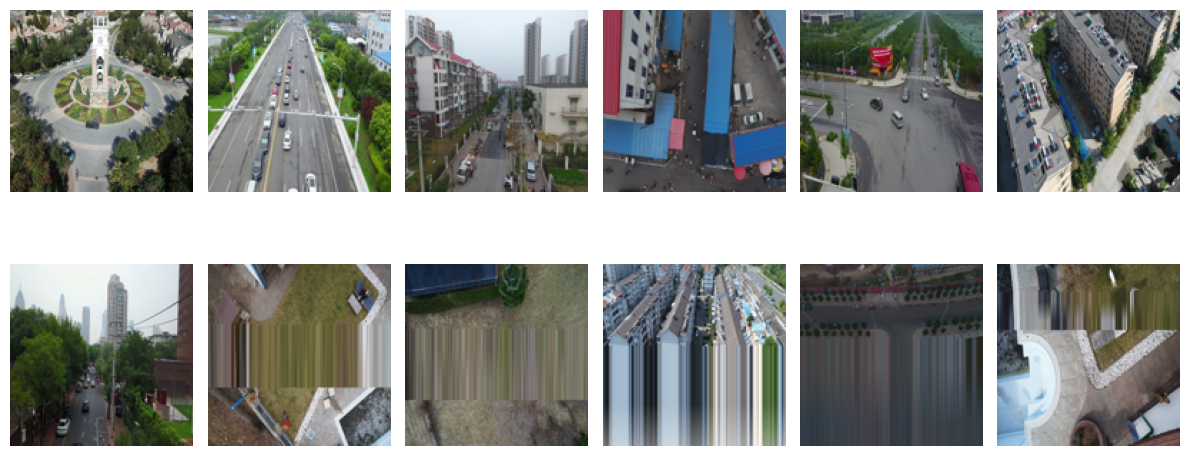

In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Plot random images from both datasets 
num_images = 6

random_truth_images = random.sample(truth_images, num_images)
random_distorted_images = random.sample(distorted_images, num_images)

fig, axes = plt.subplots(2, num_images, figsize=(12, 6))

for i, image in enumerate(random_truth_images):
    axes[0, i].imshow(image)
    axes[0, i].axis("off")

for i, image in enumerate(random_distorted_images):
    axes[1, i].imshow(image)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


In [4]:
len(truth_images)

2404

In [5]:
len(distorted_images)

2405

In [6]:
truth_images[0].shape

(128, 128, 3)

In [7]:
np.max(truth_images[300])

244

In [8]:
np.min(distorted_images[300])

1

In [9]:
from concurrent import futures

def augment_images(images, augmentation_factor):
    augmented_images = []
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.6, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    i = 0 
    for image in images:
        for _ in range(augmentation_factor):
            augmented_image = transform(image)
            augmented_images.append(augmented_image)
            if (i % 10000 ==0 ):
                print("Added augmented image to list:", i, augmented_image.shape)
            i +=1
    return augmented_images

augmentation_factor = 70

num_lists = 16
augmented_image_lists = [[] for _ in range(num_lists)]

num_images_per_list = len(truth_images) // num_lists

image_splits = []
for i in range(num_lists):
    start_idx = i * num_images_per_list
    end_idx = start_idx + num_images_per_list
    images = truth_images[start_idx:end_idx]
    image_splits.append((images, augmentation_factor))

start_time = time.time()

with futures.ThreadPoolExecutor() as executor:
    for i, (images, factor) in enumerate(image_splits):
        future = executor.submit(augment_images, images, factor)
        augmented_images = future.result()
        augmented_image_lists[i].extend(augmented_images)

end_time = time.time()
execution_time = end_time - start_time

augmented_truth_images = []
for image_list in augmented_image_lists:
    augmented_truth_images.extend(image_list)

print("Total augmented images:", len(augmented_truth_images))
print("Execution time:", execution_time, "seconds")

Added augmented image to list: 0 torch.Size([3, 128, 128])
Added augmented image to list: 10000 torch.Size([3, 128, 128])
Added augmented image to list: 0 torch.Size([3, 128, 128])
Added augmented image to list: 10000 torch.Size([3, 128, 128])
Added augmented image to list: 0 torch.Size([3, 128, 128])
Added augmented image to list: 10000 torch.Size([3, 128, 128])
Added augmented image to list: 0 torch.Size([3, 128, 128])
Added augmented image to list: 10000 torch.Size([3, 128, 128])
Added augmented image to list: 0 torch.Size([3, 128, 128])
Added augmented image to list: 10000 torch.Size([3, 128, 128])
Added augmented image to list: 0 torch.Size([3, 128, 128])
Added augmented image to list: 10000 torch.Size([3, 128, 128])
Added augmented image to list: 0 torch.Size([3, 128, 128])
Added augmented image to list: 10000 torch.Size([3, 128, 128])
Added augmented image to list: 0 torch.Size([3, 128, 128])
Added augmented image to list: 10000 torch.Size([3, 128, 128])
Added augmented image to

In [10]:
# import torch
# from torchvision import transforms

# start_time = time.time()


# augmented_truth_images = []
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(0.5),
#     transforms.RandomVerticalFlip(0.5),
#     transforms.RandomRotation(20),
#     transforms.ColorJitter(brightness=0.6, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# augmentation_factor = 50  
# for image in truth_images:
#     for _ in range(augmentation_factor):
#         augmented_truth = transform(image)
#         augmented_truth_images.append(augmented_truth)

# end_time = time.time()
# execution_time = end_time - start_time

# print("Execution time:", execution_time, "seconds")


In [11]:

transformed_distorted_images = []
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

for image in distorted_images:
    transformed_distorted = transform(image)
    transformed_distorted_images.append(transformed_distorted)

In [12]:
len(augmented_truth_images)

168000

In [13]:
len(transformed_distorted_images)

2405

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

"""
Creating dataloader from truth and distorted images list 
"""

class CustomDataset(Dataset):
    def __init__(self, images):
        self.images = images
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        return image

train_dataset = CustomDataset(augmented_truth_images)
val_dataset = CustomDataset(transformed_distorted_images)
test_dataset = CustomDataset(transformed_distorted_images)

batch_size = 128


train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

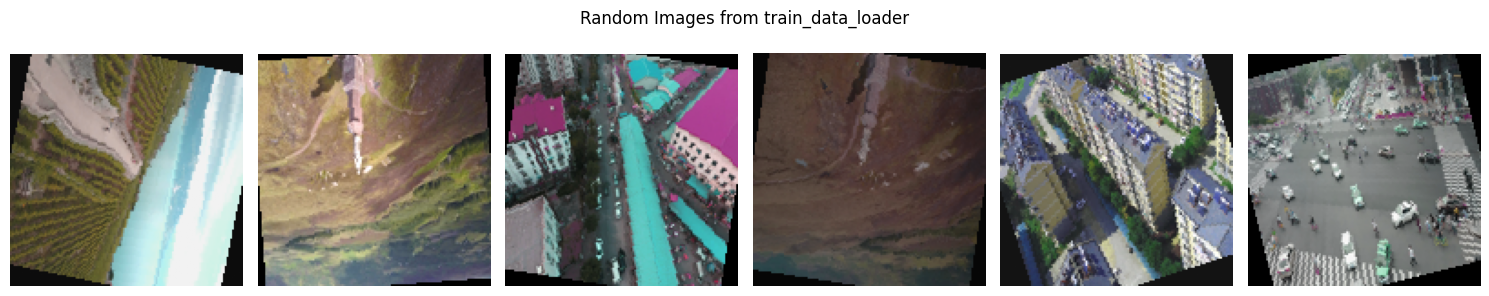

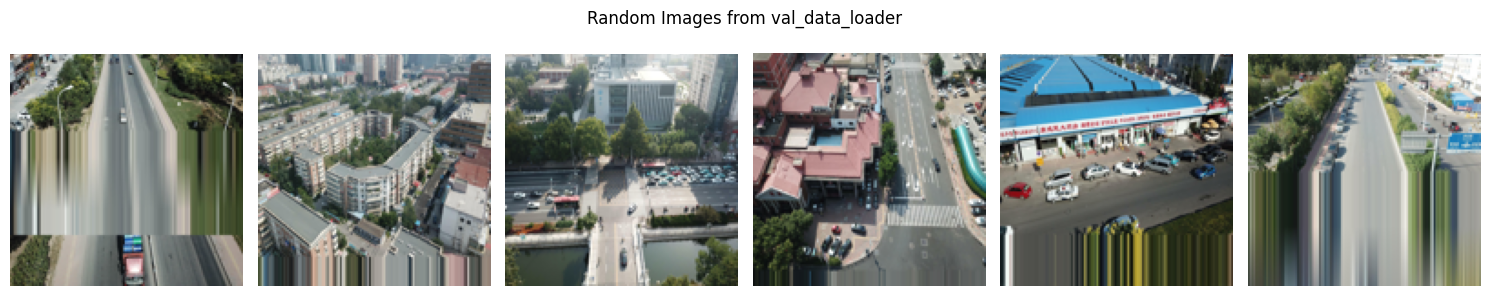

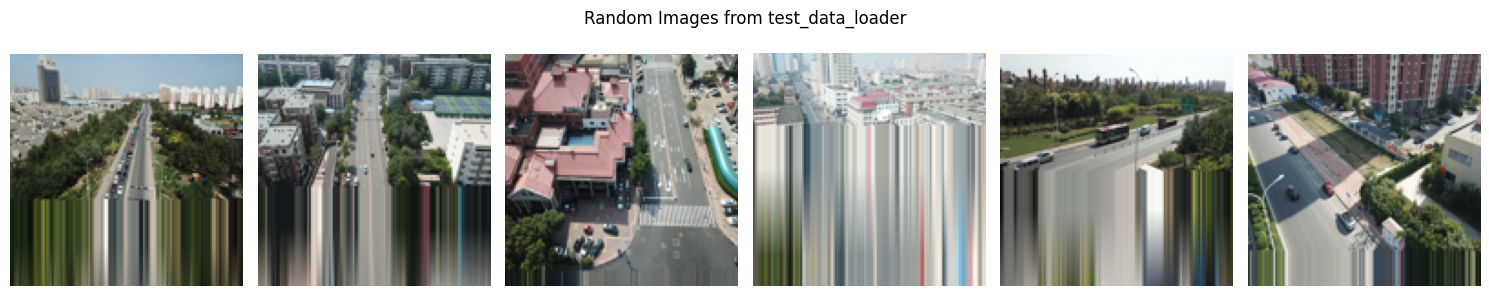

In [15]:
import matplotlib.pyplot as plt
import random

"""
Ploting from  train_data_loader, val_data_loader, test_data_loader dataloaders 
"""

def plot_images(images, title):
    fig, axes = plt.subplots(1, 6, figsize=(15, 3))
    axes = axes.flatten()

    random_images = random.sample(range(len(images)), 6)

    for i, idx in enumerate(random_images):
        image = images[idx]
        image = (image * 0.5) + 0.5  # remove normalization from transform 
        axes[i].imshow(image.permute(1, 2, 0).clamp(0, 1))
        axes[i].axis('off')

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

images = next(iter(train_data_loader))
plot_images(images, "Random Images from train_data_loader")

images = next(iter(val_data_loader))
plot_images(images, "Random Images from val_data_loader")

images = next(iter(test_data_loader))
plot_images(images, "Random Images from test_data_loader")




In [16]:
data_iter = iter(train_data_loader)
batch= next(data_iter)
print(f"Dimensions of the pairs in train_data_loader:{batch.shape}")


Dimensions of the pairs in train_data_loader:torch.Size([128, 3, 128, 128])


In [17]:
torch.manual_seed(42)

class VAEWithAttention(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, enkernel_size, enstride, enpadding):
        super(VAEWithAttention, self).__init__()
        self.latent_dim = latent_dim
       
    self.encoder = nn.Sequential(
            nn.Conv2d(3, output_dim, kernel_size=enkernel_size, stride=enstride, padding=enpadding),
            nn.Dropout(0.5),
            nn.BatchNorm2d(output_dim),
            nn.LeakyReLU(),

            nn.Conv2d(output_dim, output_dim*2, kernel_size=enkernel_size, stride=enstride, padding=enpadding),
            nn.Dropout(0.5),
            nn.BatchNorm2d(output_dim*2),
            nn.LeakyReLU(),

            nn.Conv2d(output_dim*2, output_dim*4, kernel_size=enkernel_size, stride=enstride, padding=enpadding),
            nn.Dropout(0.5),
            nn.BatchNorm2d(output_dim*4),
            nn.LeakyReLU(),
            
            # Additional Conv2d layers
            nn.Conv2d(output_dim*4, output_dim*8, kernel_size=enkernel_size, stride=enstride, padding=enpadding),
            nn.Dropout(0.5),
            nn.BatchNorm2d(output_dim*8),
            nn.LeakyReLU(),

            nn.Conv2d(output_dim*8, output_dim*16, kernel_size=enkernel_size, stride=enstride, padding=enpadding),
            nn.Dropout(0.5),
            nn.BatchNorm2d(output_dim*16),
            nn.LeakyReLU(),

            nn.Conv2d(output_dim*16, output_dim*32, kernel_size=enkernel_size, stride=enstride, padding=enpadding),
            nn.Dropout(0.5),
            nn.BatchNorm2d(output_dim*32),
            nn.LeakyReLU(),

            nn.Flatten(),
            nn.Linear((output_dim)*(output_dim)*4, hidden_dim),
            nn.Dropout(0.5),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, self.latent_dim*2),
            nn.LeakyReLU(),
        )


        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, 256 * 8 * 8),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(256 * 8 * 8),

            nn.Unflatten(1, (256, 8, 8)),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm2d(32),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        encoded = self.encoder(x)
        mean = encoded[:, :self.latent_dim]
        logvar = encoded[:, self.latent_dim:]
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z):
        decoded = self.decoder(z)
        return decoded

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)     
        x_hat = self.decode(z)
        return x_hat, mean, logvar

# # Reconstruction loss
# def reconstruction_loss(x, x_hat):
#     return nn.MSELoss()(x_hat, x)

# Regularization loss (KL divergence)
# def kl_divergence_loss(mean, logvar):
#     kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
#     return kl_loss

# Apply denoising techniques (example: Gaussian noise)
def apply_noise(images, std_dev):
    noise = torch.randn_like(images) * std_dev
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, -1, 1)
    return noisy_images

In [18]:
epochs = 100
learning_rate = 0.00016762116810071462
latent_dim = 390
hidden_dim = 300
output_dim = 32
enkernel_size =3
enstride= 2
enpadding =1

# # test model 
# # Create an instance of the VAEWithAttention model
# model = VAEWithAttention(latent_dim, hidden_dim, output_dim, enkernel_size, enstride,enpadding )

# # Input tensor for debugging
# input_tensor = torch.randn(2, 3, 128, 128)  # Adjust the shape according to your input size
# input_tensor_decoder = torch.randn(2, 176)

# with torch.no_grad():
#     for name, module in model.named_children():
#         if isinstance(module, nn.Sequential) and name.startswith('encoder'):
#             output = input_tensor
#             for i, sub_module in enumerate(module):
#                 output = sub_module(output)
#                 print(f"{name}.{i} {sub_module.__class__.__name__} output size:", output.size())
#         elif isinstance(module, nn.Sequential) and name.startswith('decoder'):     
#             output = input_tensor_decoder
#             for i, sub_module in enumerate(module):
#                 output = sub_module(output)
#                 print(f"{name}.{i} {sub_module.__class__.__name__} output size:", output.size())
#         else:
#             output = module(input_tensor)
#             print(f"{name} output size:", output.size())
# # Forward pass
# output, mean, logvar = model(input_tensor)

# # Print the shapes for debugging
# print("Input shape:", input_tensor.shape)
# print("Output shape:", output.shape)
# print("Mean shape:", mean.shape)
# print("Logvar shape:", logvar.shape)

In [19]:
# import optuna

# def objective(trial):
#     # Sample hyperparameters
#     latent_dim = trial.suggest_int("latent_dim", 50, 400)
#     learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
#     weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
#     patience = trial.suggest_int("patience", 3, 10)
#     factor = trial.suggest_float("factor", 0.01, 0.1)

weight_decay= 3.5646386699850728e-06
patience= 10
factor= 0.03226597025070396

vae = VAEWithAttention(latent_dim, hidden_dim, output_dim, enkernel_size, enstride, enpadding)
criterion = nn.MSELoss(reduction="sum")
kl_weight = 1.0
optimizer = torch.optim.AdamW(vae.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=factor)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses = []
val_losses = []  
test_losses = []  

vae.to(device)
vae.train()

start_time = time.time()

for epoch in range(epochs):
    total_loss = 0

    for images in train_data_loader:
        images = images.to(device)
        noisy_images = apply_noise(images, std_dev=0.2).to(device)

        optimizer.zero_grad()
        reconstructed_images, mean, logvar = vae(noisy_images)

        recon_loss = criterion(reconstructed_images, images)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        #loss = recon_loss + kl_weight * kl_loss
        loss = recon_loss + kl_weight * kl_loss 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_data_loader.dataset)
    train_losses.append(average_loss)

    vae.eval()
    val_loss = 0

    with torch.no_grad():
        for images in val_data_loader:
            images = images.to(device)
            reconstructed_val_images, _, _ = vae(images)
            reconstruction_val_loss = criterion(reconstructed_val_images, images)
            val_loss += reconstruction_val_loss.mean().item()

    average_val_loss = val_loss / len(val_data_loader.dataset)
    val_losses.append(average_val_loss)

    scheduler.step(val_loss)
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}")

end_time = time.time()
processing_time = end_time - start_time
print(f"Processing time: {processing_time:.2f} seconds")
    # if math.isnan(average_loss):
    #     raise optuna.exceptions.TrialPruned() 

    # Return the validation loss as the objective value
    # return average_loss

# # Optuna optimization
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=20)

# # Get the best hyperparameters
# best_params = study.best_params
# best_latent_dim = best_params["latent_dim"]
# best_learning_rate = best_params["learning_rate"]
# best_weight_decay = best_params["weight_decay"]
# best_patience = best_params["patience"]
# best_factor = best_params["factor"]

# # Print the best hyperparameters
# print("Best Hyperparameters:")
# print(f"Latent Dim: {best_latent_dim}")
# print(f"Learning Rate: {best_learning_rate}")
# print(f"Weight Decay: {best_weight_decay}")
# print(f"Patience: {best_patience}")
# print(f"Factor: {best_factor}")

torch.save(vae.state_dict(), "vae_model.pth")

Epoch [1/100], Train Loss: 10513.5611, Validation Loss: 8174.6709
Epoch [11/100], Train Loss: 2705.6108, Validation Loss: 2491.0510
Epoch [21/100], Train Loss: 2307.7593, Validation Loss: 2166.8190
Epoch [31/100], Train Loss: 2163.1087, Validation Loss: 2083.4760
Epoch [41/100], Train Loss: 2090.0640, Validation Loss: 2061.4997
Epoch [51/100], Train Loss: 2050.2191, Validation Loss: 2041.3014
Epoch [61/100], Train Loss: 2012.1041, Validation Loss: 2040.4834
Epoch [71/100], Train Loss: 1988.0665, Validation Loss: 2043.9960
Epoch [81/100], Train Loss: 1966.8711, Validation Loss: 2039.5594
Epoch [91/100], Train Loss: 1906.7762, Validation Loss: 2016.6861
Processing time: 4206.51 seconds


Test Loss (0): 136.8551
Test Loss (1): 284.0070
Test Loss (2): 390.7556
Test Loss (3): 498.2015
Test Loss (4): 606.5823
Test Loss (5): 703.1543
Test Loss (6): 760.8796
Test Loss (7): 817.4842
Test Loss (8): 896.0145
Test Loss (9): 986.2808
Test Loss (10): 1087.0895
Test Loss (11): 1183.2878
Test Loss (12): 1294.6923
Test Loss (13): 1414.9311
Test Loss (14): 1538.7955
Test Loss (15): 1666.7067
Test Loss (16): 1792.5264
Test Loss (17): 1917.3864
Test Loss (18): 2017.0006


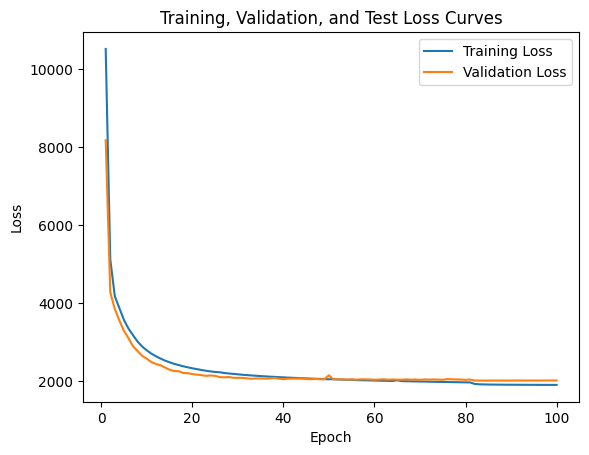

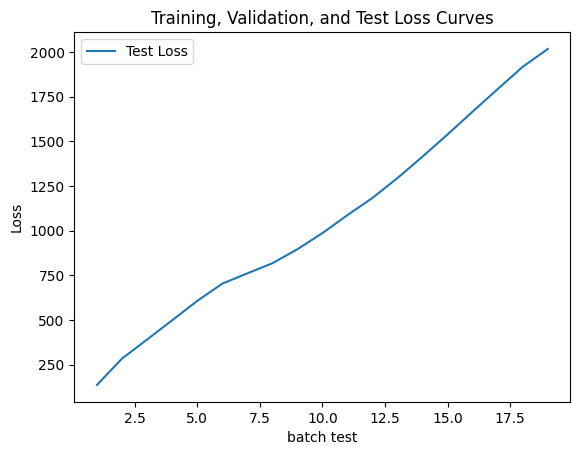

In [20]:
# Evaluation on test dataset
vae.eval()
test_loss = 0
test_losses =[]
i = 0 
with torch.no_grad():
    for images in test_data_loader:
        images = images.to(device)
        reconstructed_test_images, _, _ = vae(images)
        reconstruction_test_loss = criterion(reconstructed_test_images, images)
        test_loss += reconstruction_test_loss.mean().item()

        average_test_loss = test_loss / len(test_data_loader.dataset)
        test_losses.append(average_test_loss)
        print(f"Test Loss ({i}): {average_test_loss:.4f}")
        i += 1
     

plt.Figure()
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss Curves')
plt.legend()
plt.show()

plt.Figure()
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
plt.xlabel('batch test')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss Curves')
plt.legend()
plt.show()



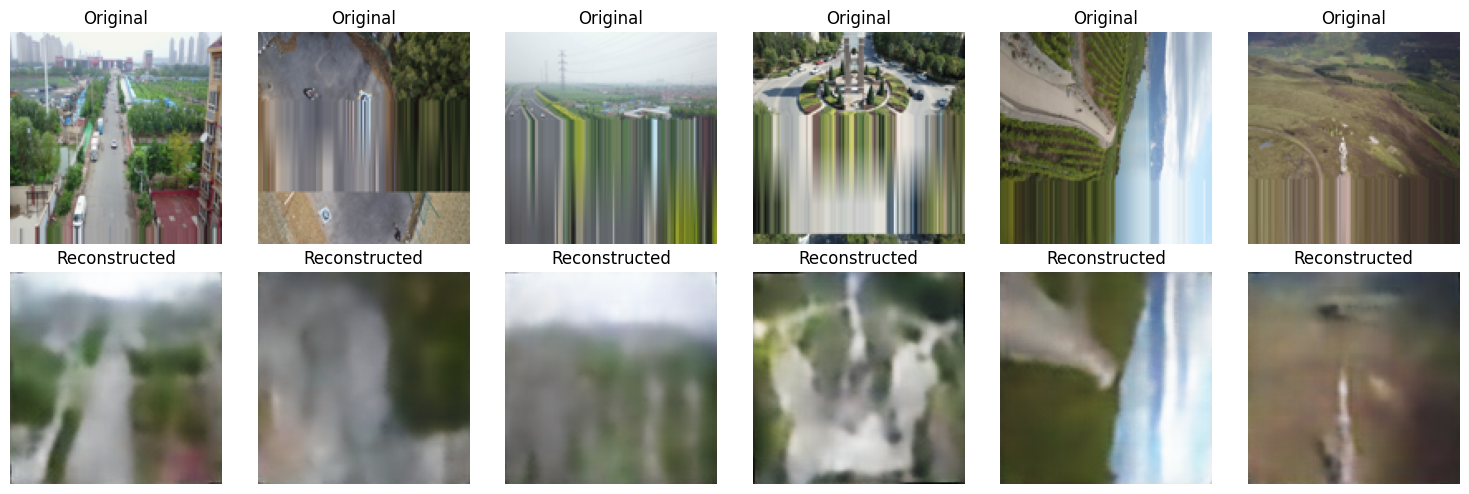

In [24]:
import matplotlib.pyplot as plt
import random
from torchvision import models

"""
Ploting 6 random pairs of images from the test_data_loader
We load the model to make space in the memory 
"""

def plot_image_pairs(original_images, reconstructed_images):
    fig, axes = plt.subplots(2, 6, figsize=(15, 5))
    axes = axes.flatten()

    for i in range(6):
        axes[i].imshow(original_images[i].detach().cpu().permute(1, 2, 0).clamp(0, 1))
        axes[i].axis('off')
        axes[i].set_title("Original")

        axes[i + 6].imshow(reconstructed_images[i].detach().cpu().permute(1, 2, 0).clamp(0, 1))
        axes[i + 6].axis('off')
        axes[i + 6].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAEWithAttention(latent_dim, hidden_dim, output_dim, enkernel_size, enstride, enpadding)
vae = vae.to(device)  
        
vae.load_state_dict(torch.load("vae_model.pth"))    
    
vae.eval()

random_pairs = random.sample(list(test_data_loader), 6)

original_images = []
reconstructed_images = []

for images in random_pairs:
    images = images.to(device)
    
    reconstructed_test_images, _, _ = vae(images)
        
    
    original_images.append((images[0]* 0.5) + 0.5)
    reconstructed_images.append((reconstructed_test_images[0]* 0.5) + 0.5)

plot_image_pairs(original_images, reconstructed_images)

